## Регрессия
Задача: предсказать зарплату игрока НХЛ по его статистике с использованием модели случайного леса.

Будем использовать MAE, так как она очень наглядная, будет легко понять, насколько долларов ошибается модель. В качестве дополнительной метрики будем использовать R^2, чтобы смотреть насколько отличается предсказание от среднего.

### Baseline Random Forest

In [87]:
import kagglehub
import pandas as pd
import numpy as np

path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")

df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [88]:
df['Born'] = pd.to_datetime(df['Born'], format='%y-%m-%d')
df_clean = df.fillna(0)
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean = df_clean.drop("Born", axis=1)

In [89]:
from sklearn.model_selection import train_test_split

TARGET_NAME = "Salary"
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [90]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, [y_train.mean()]*len(y_test))

print(f"--- Baseline LinearRegreesion (Raw Data) ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

--- Baseline LinearRegreesion (Raw Data) ---
MAE (Ошибка в долларах): 958003.039
R2 Score: 0.606


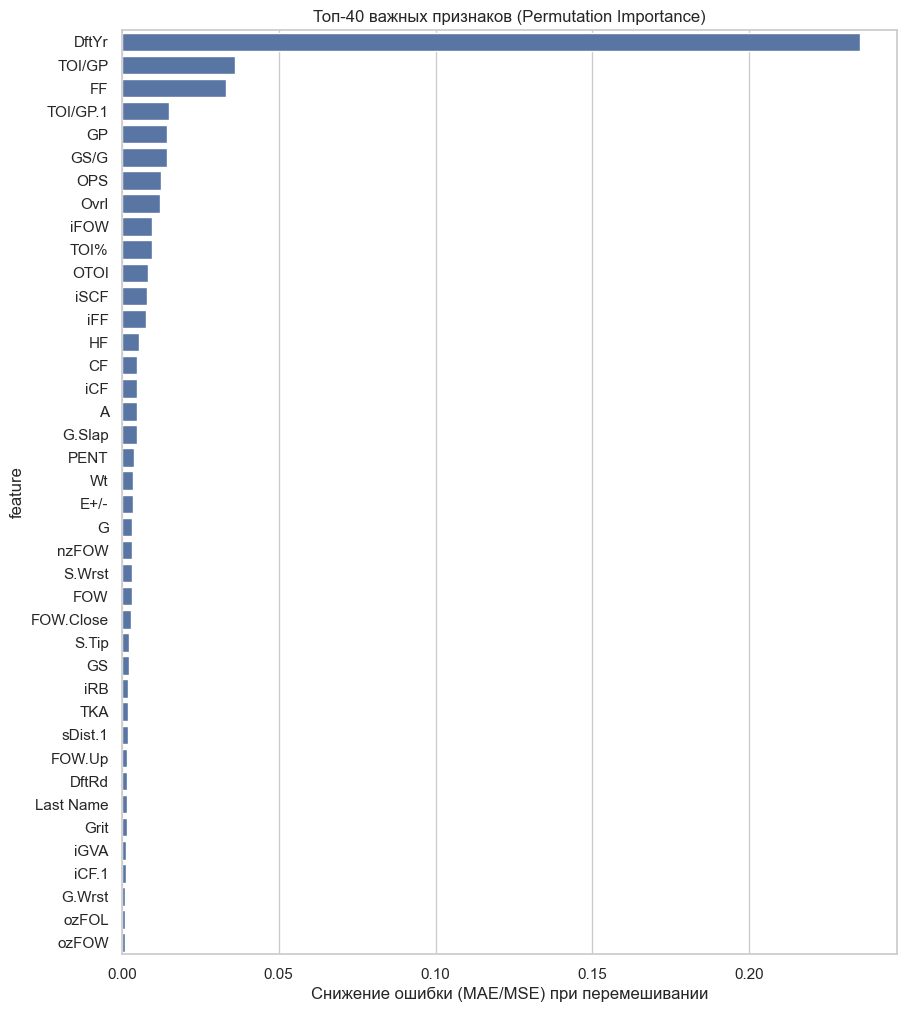

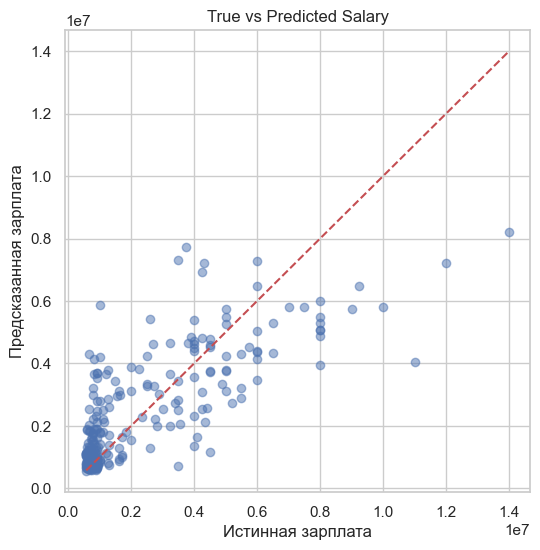

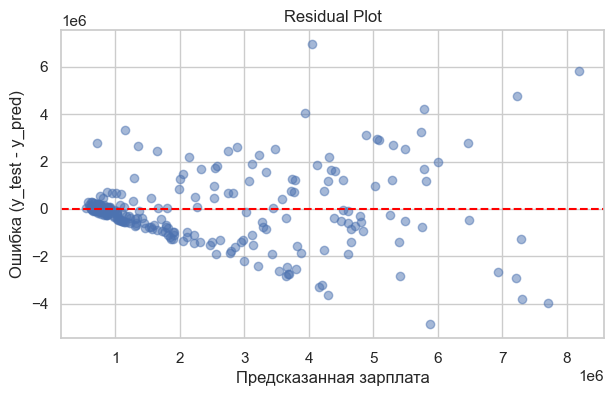

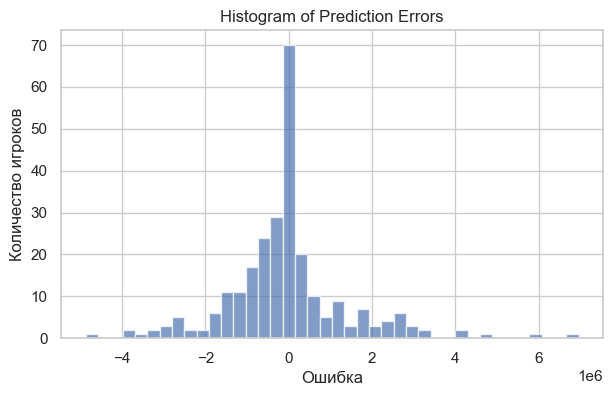

In [91]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.inspection import permutation_importance

def important_features(model, X_test, y_test):
    perm_result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=10,
        random_state=52,
        n_jobs=-1
    )

    perm_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': perm_result.importances_mean
    })

    top_40_perm = perm_df.sort_values(by='importance', ascending=False).head(40)

    plt.figure(figsize=(10, 12))
    sns.barplot(data=top_40_perm, x='importance', y='feature')
    plt.title("Топ-40 важных признаков (Permutation Importance)")
    plt.xlabel("Снижение ошибки (MAE/MSE) при перемешивании")
    plt.show()

def true_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Истинная зарплата")
    plt.ylabel("Предсказанная зарплата")
    plt.title("True vs Predicted Salary")
    plt.grid(True)
    plt.show()

def resudial(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(7,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Предсказанная зарплата")
    plt.ylabel("Ошибка (y_test - y_pred)")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.show()
def histogramm_error(y_test, y_pred):
    plt.figure(figsize=(7,4))
    residuals = y_test - y_pred
    plt.hist(residuals, bins=40, alpha=0.7)
    plt.title("Histogram of Prediction Errors")
    plt.xlabel("Ошибка")
    plt.ylabel("Количество игроков")
    plt.grid(True)
    plt.show()

important_features(model, X_test, y_test)
true_vs_predicted(y_test, y_pred)
resudial(y_test, y_pred)
histogramm_error(y_test, y_pred)

Бэйзлайн градиентного бустинга выдал очень приличный результат. Модель лучше определяет зарплаты более дорогих хоккеистов, однако эта модель стала худше справляется с более дешевыми, более распыленными стали точки вокруг главной диагонали.

### Improved Gradient Boosting

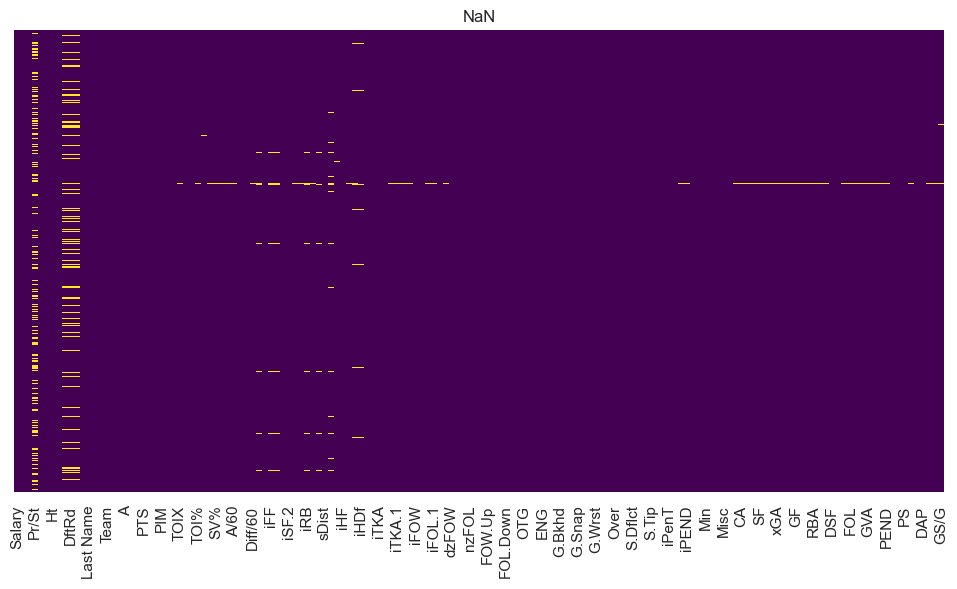

In [92]:
import kagglehub
from matplotlib import pyplot as plt
import seaborn as sns

path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")
df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)

nulls = df.isna().sum().sort_values(ascending=False)
null_pct = (nulls / len(df)).mul(100).round(2)

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("NaN")
plt.show()

In [93]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Salary,874.0,2.325289e+06,2.298253e+06,575000.00,742500.00,925000.00,3700000.00,14000000.00
Ht,874.0,7.308238e+01,2.105485e+00,66.00,72.00,73.00,75.00,81.00
Wt,874.0,2.008432e+02,1.506008e+01,157.00,190.00,200.00,210.00,265.00
DftYr,749.0,2.008708e+03,4.380158e+00,1990.00,2006.00,2010.00,2012.00,2016.00
DftRd,749.0,2.742323e+00,1.988358e+00,1.00,1.00,2.00,4.00,9.00
...,...,...,...,...,...,...,...,...
Grit,874.0,1.267815e+02,1.016121e+02,0.00,41.00,114.00,190.00,622.00
DAP,874.0,9.215675e+00,7.815029e+00,0.00,4.60,7.60,12.00,61.00
Pace,873.0,1.089439e+02,8.899877e+00,75.00,104.70,109.20,113.90,175.70
GS,873.0,2.187331e+01,2.198638e+01,-4.30,2.60,15.70,35.40,104.70


In [94]:
import pandas as pd
import numpy as np

num_cols = df.select_dtypes(include=["int64", "float64"]).columns

corr_matrix = df[num_cols].corr()

corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']

corr_pairs = corr_pairs[corr_pairs['feature_1'] < corr_pairs['feature_2']]

corr_pairs = corr_pairs.reindex(
    corr_pairs['correlation'].abs().sort_values(ascending=False).index
)

top40 = corr_pairs.head(40)

display(top40)
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_corr = corr_matrix.where(upper)
to_drop = [col for col in upper_corr.columns if any(upper_corr[col] > 0.998)]

df_clean = df.drop(columns=to_drop)

df_clean.head()

,feature_1,feature_2,correlation
4931,iSF.1,iSF.2,0.999996
8267,iFOL,iFOL.1,0.999981
8122,iFOW,iFOW.1,0.999979
6381,iHF,iHF.1,0.999957
2321,TOI,TOIX,0.999952
7398,iBLK,iBLK.1,0.999948
4787,iSF,iSF.2,0.999937
4786,iSF,iSF.1,0.999931
7108,iGVA,iGVA.1,0.999907
7253,iTKA,iTKA.1,0.999843


,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [95]:
df_features = df_clean.copy()

df_features['Born'] = pd.to_datetime(df_features['Born'], format='%y-%m-%d')
reference_date = pd.Timestamp('2016-10-01')
df_features['Age'] = (reference_date - df_features['Born']).dt.days / 365.25

df_features['Experience'] = reference_date.year - df_features['DftYr']
df_features['Age_squared'] = df_features['Age'] ** 2
df_features['PTS_per_GP'] = df_features['PTS'] / df_features['GP'].replace(0, 1)
df_features['Is_Drafted'] = df_features['DftYr'].notna().astype(int)
df_features['Physical_Impact'] = df_features['Wt'] * df_features['Ht']

features_to_drop = ['Born', 'Last Name', 'First Name', 'Nat', 'Pr/St', 'City']
df_features = df_features.drop(features_to_drop, axis=1)
df_features['Match'].value_counts()

Match
0    870
1      4
Name: count, dtype: int64

In [96]:
has_nan = df_features.isnull().any()

columns_with_nan = has_nan[has_nan].index.tolist()

print("Столбцы, содержащие хотя бы один NaN:")
columns_with_nan

Столбцы, содержащие хотя бы один NaN:


['DftYr',
 'DftRd',
 'Ovrl',
 'TOI%',
 'IPP%',
 'SH%',
 'SV%',
 'PDO',
 'F/60',
 'A/60',
 'Diff/60',
 'iCF',
 'iFF',
 'iSF',
 'ixG',
 'iSCF',
 'iRB',
 'iRS',
 'iDS',
 'sDist.1',
 'Pass',
 'iHA',
 'iHDf',
 'BLK%',
 '%FOT',
 'iPENT',
 'iPEND',
 'CF',
 'CA',
 'xGF',
 'xGA',
 'SCF',
 'SCA',
 'GF',
 'GA',
 'RBF',
 'RBA',
 'RSF',
 'RSA',
 'FOW',
 'FOL',
 'HF',
 'HA',
 'GVA',
 'TKA',
 'PENT',
 'PEND',
 'OTOI',
 'Pace',
 'GS',
 'GS/G',
 'Experience']

In [97]:
TARGET_NAME = 'Salary'

X_i = df_features.drop(TARGET_NAME, axis=1)
y_i = df_features[TARGET_NAME]

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_i, y_i, test_size=0.3, random_state=42
)

In [98]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

cat_cols = X_i.select_dtypes(include=['object', 'category']).columns.tolist()

cat_branch = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_cols = X_i.select_dtypes(include=["int64", "float64"]).columns

num_branch = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

ct = ColumnTransformer(
    transformers=[
        ("cat_proc", cat_branch, cat_cols),
        ("num_proc", num_branch, num_cols),
    ], remainder='drop'
)

В данном случае я использовать реализацию градиентного бустинга из scikit-learn, перебрал внутренние параметры дерева, штраф регуляризации и прочее. Использовал RandomSearch, потому что Grid ОЧЕНЬ долго обучался конечно.

In [99]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

full_pipeline = Pipeline([
    ('preprocessor', ct),
    ('model_wrapper', TransformedTargetRegressor(
        regressor=GradientBoostingRegressor(random_state=42),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

from scipy.stats import randint, uniform

param_dist = {
    'model_wrapper__regressor__n_estimators': randint(200, 800),
    'model_wrapper__regressor__learning_rate': uniform(0.01, 0.2),
    'model_wrapper__regressor__max_depth': randint(3, 7),
    'model_wrapper__regressor__min_samples_leaf': randint(7, 15),
    'model_wrapper__regressor__subsample': uniform(0.6, 0.4),
}


scoring = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}
grid = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring=scoring,
    refit='MAE',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

grid.fit(X_train_i, y_train_i)

print("Лучшие параметры:", grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test_i)
y_pred_train = grid.best_estimator_.predict(X_train_i)

mae = mean_absolute_error(y_test_i, y_pred)
train_mae = mean_absolute_error(y_train_i, y_pred_train)
r2 = r2_score(y_test_i, y_pred)

print(f"\n--- Gradient Boosting Regressor ---")
print(f"MAE: {mae:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"R2 Score: {r2:.3f}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Лучшие параметры: {'model_wrapper__regressor__learning_rate': np.float64(0.014612485008283152), 'model_wrapper__regressor__max_depth': 5, 'model_wrapper__regressor__min_samples_leaf': 9, 'model_wrapper__regressor__n_estimators': 710, 'model_wrapper__regressor__subsample': np.float64(0.6557975442608167)}

--- Gradient Boosting Regressor ---
MAE: 850100.263
Train MAE: 182388.563
R2 Score: 0.640


Кажется, бустинг переучился. Но метрика получилась лучшей из всех моделей, поэтому я думаю, что это не очень критично.

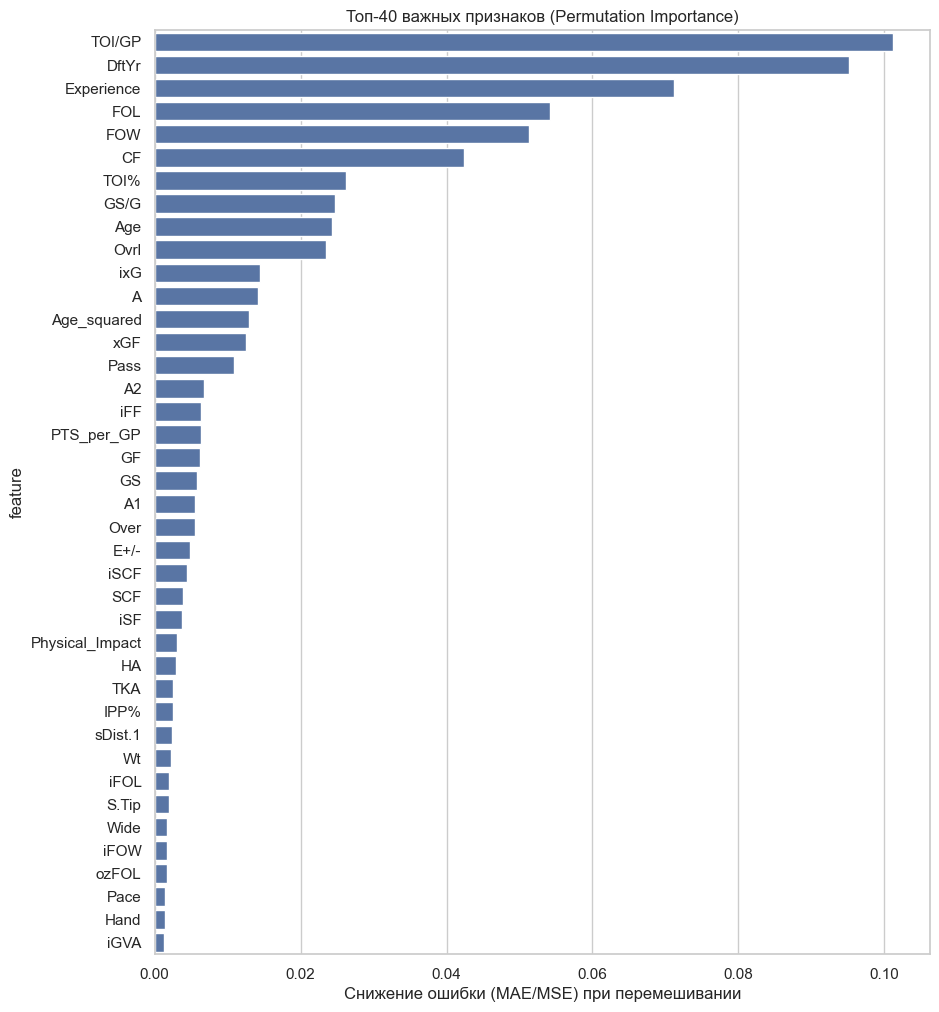

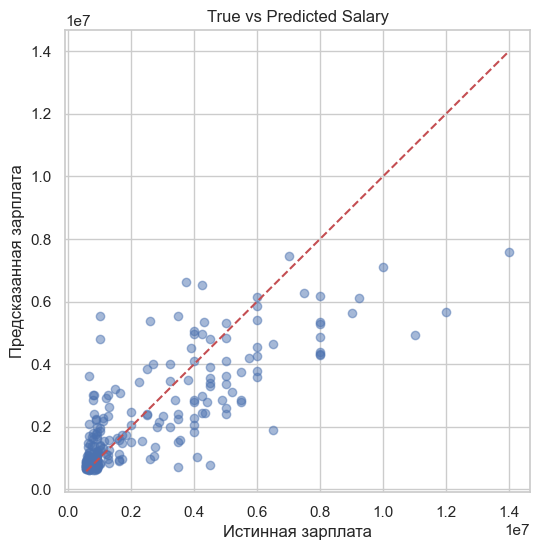

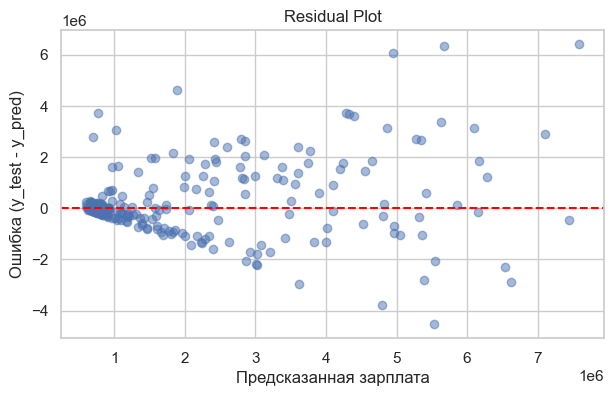

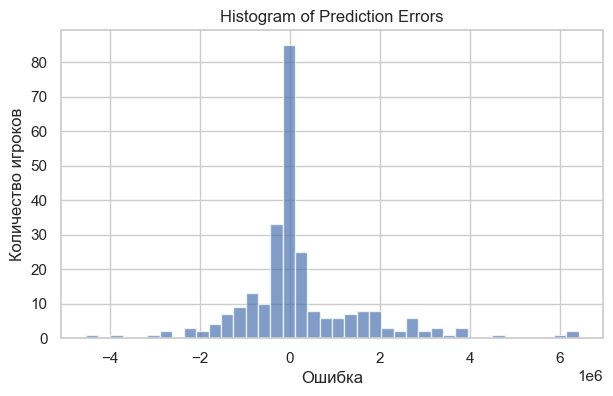

In [100]:
important_features(grid.best_estimator_, X_test_i, y_test_i)
true_vs_predicted(y_test_i, y_pred)
resudial(y_test_i, y_pred)
histogramm_error(y_test_i, y_pred)

Бустинг показал лучшую ключевую метрику, он неплохо справляется как с дорогими, так и с дешёвыми хоккеистами. Единственное, что смущает -- это переобучение.

In [101]:
import pandas as pd
import numpy as np

original_float_format = pd.get_option('display.float_format')

pd.set_option('display.float_format', '{:.2f}'.format)

best_model = grid.best_estimator_

y_full_pred = best_model.predict(X_i)

results_df = pd.DataFrame({
    'True_Salary': y_i,
    'Predicted_Salary': y_full_pred
})

results_df['Absolute_Error'] = np.abs(results_df['True_Salary'] - results_df['Predicted_Salary'])

test_indices = X_test.index
final_results = pd.merge(
    df[['First Name', 'Last Name']],
    results_df,
    left_index=True,
    right_index=True
)

final_results_sorted = final_results.sort_values(by='Absolute_Error', ascending=False)

print("\n--- Топ-10 игроков с наибольшей ошибкой (Train & Test) ---")
print(final_results_sorted.head(10).to_string())

pd.set_option('display.float_format', original_float_format)


--- Топ-10 игроков с наибольшей ошибкой (Train & Test) ---
    First Name  Last Name  True_Salary  Predicted_Salary  Absolute_Error
626       Anze    Kopitar  14000000.00        7588145.65      6411854.35
542       Shea      Weber  12000000.00        5668397.58      6331602.42
208       P.K.     Subban  11000000.00        4943771.39      6056228.61
721       Sean    Monahan   6500000.00        1887067.06      4612932.94
532      Radim     Vrbata   1000000.00        5533651.13      4533651.13
110       Luke     Schenn   1000000.00        4790963.70      3790963.70
620     Clarke  MacArthur   4500000.00         773747.60      3726252.40
497     Andrew       Ladd   8000000.00        4284315.37      3715684.63
787      Derek     Stepan   8000000.00        4320848.47      3679151.53
148   Vladimir  Tarasenko   8000000.00        4399066.98      3600933.02


In [102]:
import pandas as pd
final_results['Signed_Error'] = final_results['Predicted_Salary'] - final_results['True_Salary']

overestimated_players = final_results[final_results['Signed_Error'] > 0].copy()

top_overestimated = overestimated_players.sort_values(by='Signed_Error', ascending=False)

print("\n--- Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---")

print(top_overestimated[['First Name', 'Last Name',
                         'True_Salary', 'Predicted_Salary', 'Signed_Error']].head(10).to_string())


--- Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---
    First Name Last Name  True_Salary  Predicted_Salary  Signed_Error
532      Radim    Vrbata    1000000.0      5.533651e+06  4.533651e+06
110       Luke    Schenn    1000000.0      4.790964e+06  3.790964e+06
849        Sam    Gagner     650000.0      3.623715e+06  2.973715e+06
584    Vincent  Trocheck    3750000.0      6.619976e+06  2.869976e+06
440     Thomas     Vanek    2600000.0      5.391430e+06  2.791430e+06
286     Victor    Hedman    4250000.0      6.539313e+06  2.289313e+06
412       Mark  Barberio     800000.0      3.021040e+06  2.221040e+06
316   Jonathan    Drouin     832500.0      3.009321e+06  2.176821e+06
302        Tom     Pyatt     800000.0      2.864126e+06  2.064126e+06
326     Martin    Hanzal    3500000.0      5.546232e+06  2.046232e+06


Ожидания не оправдались, градиентный бустинг оказался хуже для этой задачи, чем HuberLinearRegression. Последняя меньше склонна к переобучению, даёт лучший MAE, да и в целом проще.

### My implementation

In [103]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyGradientBoostingRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def fit(self, X, y):
        X, y = check_X_y(X, y, ensure_2d=True)
        self.initial_pred_ = np.mean(y)
        current_prediction = np.full(y.shape, self.initial_pred_)
        self.estimators_ = []

        for m in range(self.n_estimators):
            residual = y - current_prediction
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf
            )
            tree.fit(X, residual)

            tree_predictions = tree.predict(X)

            current_prediction += self.learning_rate * tree_predictions
            self.estimators_.append(tree)

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        final_prediction = np.full(X.shape[0], self.initial_pred_)
        for tree in self.estimators_:
            tree_predictions = tree.predict(X)
            final_prediction += self.learning_rate * tree_predictions
        return final_prediction

In [104]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, [y_train.mean()]*len(y_test))

print(f"--- My gradient boosting (Raw Data) ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

--- My gradient boosting (Raw Data) ---
MAE (Ошибка в долларах): 963214.967
R2 Score: 0.601


In [105]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

full_pipeline = Pipeline([
    ('preprocessor', ct),
    ('model_wrapper', TransformedTargetRegressor(
        regressor=MyGradientBoostingRegressor(),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

param_grid = {
    'model_wrapper__regressor__n_estimators': [500],
    'model_wrapper__regressor__max_depth': [3, 5, 7],
    'model_wrapper__regressor__learning_rate': [0.005],
}

scoring = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}
grid = RandomizedSearchCV(
    full_pipeline,
    param_grid,
    cv=3,
    scoring=scoring,
    refit='MAE',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print("Лучшие параметры:", grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test_i)
y_pred_train = grid.best_estimator_.predict(X_train_i)

mae = mean_absolute_error(y_test_i, y_pred)
train_mae = mean_absolute_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_test_i, y_pred))
r2 = r2_score(y_test_i, y_pred)
base_mean_error = mean_absolute_error(y_test_i, [y_train.mean()] * len(y_test_i))

print(f"\n--- Gradient Boosting Regressor ---")
print(f"MAE: {mae:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"R2 Score: {r2:.3f}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры: {'model_wrapper__regressor__n_estimators': 500, 'model_wrapper__regressor__max_depth': 3, 'model_wrapper__regressor__learning_rate': 0.005}

--- Gradient Boosting Regressor ---
MAE: 915490.977
Train MAE: 720022.157
R2 Score: 0.569


Собственная имплементация градиентного бустинга показала чуть более плохой скор, чем из scikit-learn. Собственная имплементация не учитывает некоторые гиперпараметры, с которыми работает библиотечная модель, что может влиять на результат. В целом разница в 15 тысяч -- это в пределах погрешности.

|     | Base Gradient Boosting | Gradient Boosting | My Random Forest |
|-----|------------------------|-------------------|------------------|
| MAE | 963131.492             | 850100.263        | 915546.804       |
| R2  | 0.604                  | 0.560             | 0.569            |

## Классификация
Задача: вычислить мошенника на страховых выплатах с использованием модели случайного леса

Для выполнения лабораторной работы были выбраны метрики F1-score и ROC-AUC, так как исследуемый датасет является несбалансированным. Метрика Accuracy в данном случае неинформативна, так как модель, предсказывающая всем класс ‘0’ (не фрод), может иметь высокую Accuracy, но будет бесполезна. F1-score позволит контролировать баланс между ложными срабатываниями и пропуском мошенников.

### Baseline

In [106]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "buntyshah/auto-insurance-claims-data/versions/1",
                                  "insurance_claims.csv")
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,?,87200,17440,8720,61040,Honda,Accord,2006,N,NaN
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NaN
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,NaN
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,N,NaN


In [107]:
df_clean = df.copy()

TARGET_NAME = "fraud_reported"
df_clean["fraud_reported"] = df_clean["fraud_reported"].map({'Y': 1, 'N': 0})
df_clean["police_report_available"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0}).fillna(-1)
df_clean["property_damage"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0}).fillna(-1)

In [108]:
df_clean = df_clean.drop(columns=["_c39"])

In [109]:
date_cols = ["policy_bind_date", "incident_date"]
for c in date_cols:
    df_clean[c] = pd.to_datetime(df_clean[c], errors="coerce")

In [110]:
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,2,1,1000,1406.91,0,466132,...,2,1.0,71610,6510,13020,52080,10,1,2004,1
1,228,42,342868,2006-06-27,1,1,2000,1197.22,5000000,468176,...,0,-1.0,5070,780,780,3510,8,12,2007,1
2,134,29,687698,2000-09-06,2,0,2000,1413.14,5000000,430632,...,3,0.0,34650,7700,3850,23100,4,30,2007,0
3,256,41,227811,1990-05-25,0,1,2000,1415.74,6000000,608117,...,2,0.0,63400,6340,6340,50720,3,34,2014,1
4,228,44,367455,2014-06-06,0,2,1000,1583.91,6000000,610706,...,1,0.0,6500,1300,650,4550,0,31,2009,0


In [111]:
from sklearn.model_selection import train_test_split
drop_dates = ["policy_bind_date", "incident_date"]
df_clean = df_clean.drop(drop_dates, axis=1)
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [112]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

F1-score (класс 1): 0.6497
ROC-AUC: 0.8359
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       226
           1       0.61      0.69      0.65        74

    accuracy                           0.82       300
   macro avg       0.75      0.77      0.76       300
weighted avg       0.83      0.82      0.82       300

Confusion Matrix:
[[194  32]
 [ 23  51]]


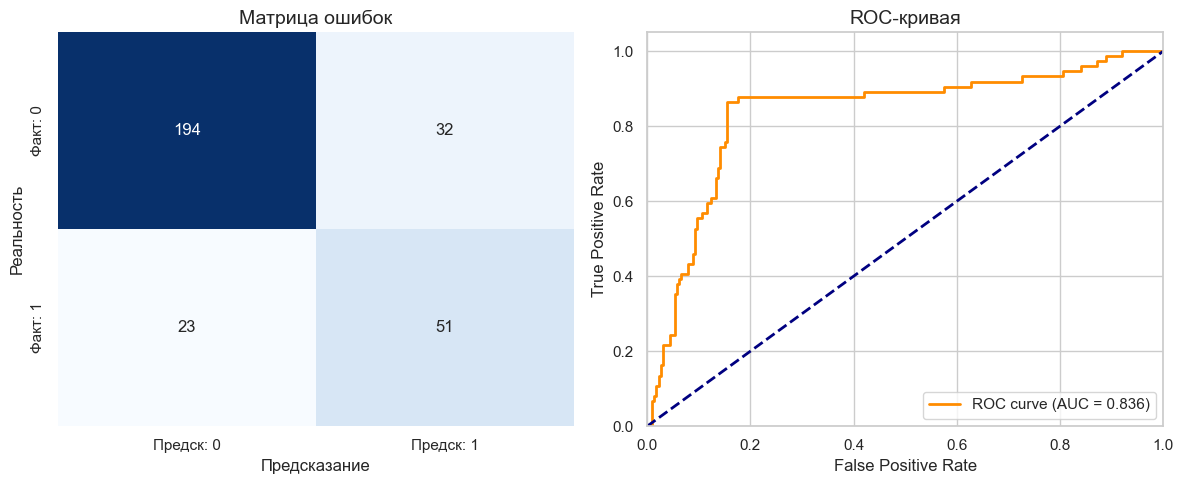

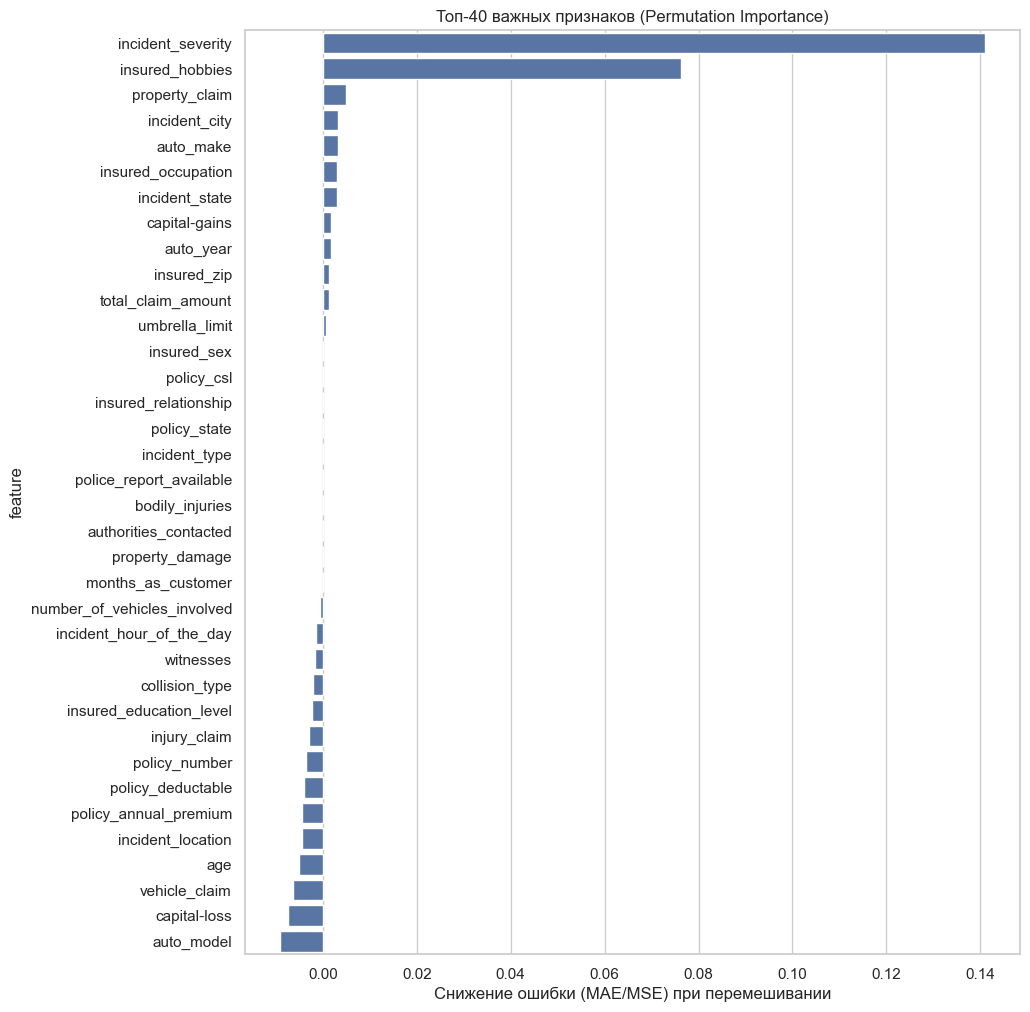

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
def graphics(y_test, y_pred, y_prob):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=['Предск: 0', 'Предск: 1'],
                yticklabels=['Факт: 0', 'Факт: 1'])
    plt.title("Матрица ошибок", fontsize=14)
    plt.ylabel("Реальность")
    plt.xlabel("Предсказание")

    plt.subplot(1, 2, 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая', fontsize=14)
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()
def feature_important(model, X_test, y_test):

    perm_result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    perm_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': perm_result.importances_mean
    })

    top_40_perm = perm_df.sort_values(by='importance', ascending=False).head(40)

    plt.figure(figsize=(10, 12))
    sns.barplot(data=top_40_perm, x='importance', y='feature')
    plt.title("Топ-40 важных признаков (Permutation Importance)")
    plt.xlabel("Снижение ошибки (MAE/MSE) при перемешивании")
    plt.show()
graphics(y_test, y_pred, y_prob)
feature_important(model, X_test, y_test)

Бустинг нашёл больше мошенников. Сработал лучше, нашёл больше мошенников даже без предобработки данных.

### Improved Gradien Boosting

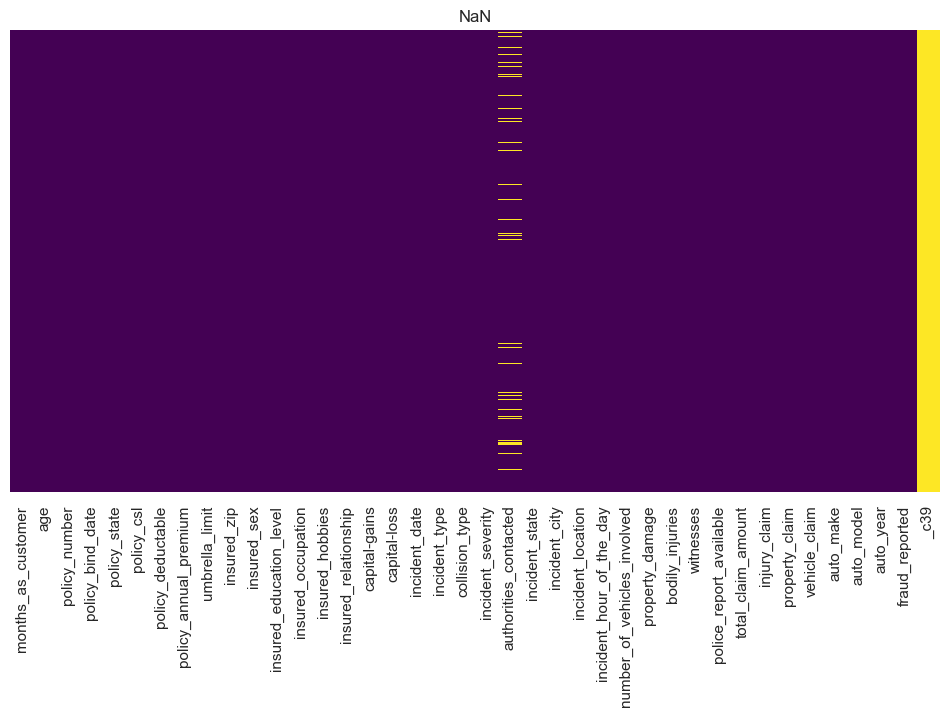

In [114]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "buntyshah/auto-insurance-claims-data/versions/1",
                                  "insurance_claims.csv")
df.head()

nulls = df.isna().sum().sort_values(ascending=False)
null_pct = (nulls / len(df)).mul(100).round(2)

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("NaN")
plt.show()

In [115]:
df_clean = df.copy()
df_clean["fraud_reported"].value_counts()

fraud_reported
N    753
Y    247
Name: count, dtype: int64

In [116]:
display(df_clean["police_report_available"].unique())
display(df_clean["property_damage"].unique())

array(['YES', '?', 'NO'], dtype=object)

array(['YES', '?', 'NO'], dtype=object)

In [117]:
df_clean = df_clean.drop(columns=["_c39"])

df_clean["authorities_contacted"] = df_clean["authorities_contacted"].fillna("No Contact")

TARGET_NAME = "fraud_reported"
df_clean["fraud_reported"] = df_clean["fraud_reported"].map({'Y': 1, 'N': 0})
df_clean["police_report_available"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0, '?': -1})
df_clean["property_damage"] = df_clean["property_damage"].map({'YES': 1, 'NO': 0, '?': -1})

dates_cols = ["policy_bind_date", "incident_date"]
for c in date_cols:
    df_clean[c] = pd.to_datetime(df_clean[c])

df_clean

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,1,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,-1,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,0,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,0,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,0,6500,1300,650,4550,Accura,RSX,2009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,1,-1,87200,17440,8720,61040,Honda,Accord,2006,0
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,3,-1,108480,18080,18080,72320,Volkswagen,Passat,2015,0
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,3,1,67500,7500,7500,52500,Suburu,Impreza,1996,0
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,1,1,46980,5220,5220,36540,Audi,A5,1998,0


In [118]:
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
df_clean[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.0,2.039540e+02,1.151132e+02,0.00,115.7500,199.5,276.250,479.00
age,1000.0,3.894800e+01,9.140287e+00,19.00,32.0000,38.0,44.000,64.00
policy_number,1000.0,5.462386e+05,2.570630e+05,100804.00,335980.2500,533135.0,759099.750,999435.00
policy_deductable,1000.0,1.136000e+03,6.118647e+02,500.00,500.0000,1000.0,2000.000,2000.00
policy_annual_premium,1000.0,1.256406e+03,2.441674e+02,433.33,1089.6075,1257.2,1415.695,2047.59
umbrella_limit,1000.0,1.101000e+06,2.297407e+06,-1000000.00,0.0000,0.0,0.000,10000000.00
insured_zip,1000.0,5.012145e+05,7.170161e+04,430104.00,448404.5000,466445.5,603251.000,620962.00
capital-gains,1000.0,2.512610e+04,2.787219e+04,0.00,0.0000,0.0,51025.000,100500.00
capital-loss,1000.0,-2.679370e+04,2.810410e+04,-111100.00,-51500.0000,-23250.0,0.000,0.00
incident_hour_of_the_day,1000.0,1.164400e+01,6.951373e+00,0.00,6.0000,12.0,17.000,23.00


In [119]:
import numpy as np

df_pr = df_clean.copy()

median_value = df_pr.loc[df_pr['umbrella_limit'] != -100000, 'umbrella_limit'].median()
df_pr.loc[df_pr['umbrella_limit'] == -100000, 'umbrella_limit'] = median_value

In [120]:
df_features = df_pr.copy()

df_clean["policy_tenure_months"] = ((df_clean["incident_date"] - df_clean["policy_bind_date"]).dt.days / 30).astype(int)

df_features["incident_year"] = df_features["incident_date"].dt.year
df_features["incident_month"] = df_features["incident_date"].dt.month
df_features["incident_dow"] = df_features["incident_date"].dt.dayofweek
df_features["is_weekend"] = df_features["incident_dow"].isin([5, 6]).astype(int)

df_features["injury_ratio"] = df_features["injury_claim"] / (df_features["total_claim_amount"] + 1e-3)
df_features["property_ratio"] = df_features["property_claim"]  / (df_features["total_claim_amount"] + 1e-3)
df_features["vehicle_ratio"] = df_features["vehicle_claim"] / (df_features["total_claim_amount"] + 1e-3)

drop_dates = ["policy_bind_date", "incident_date"]
df_features = df_features.drop(drop_dates, axis=1)

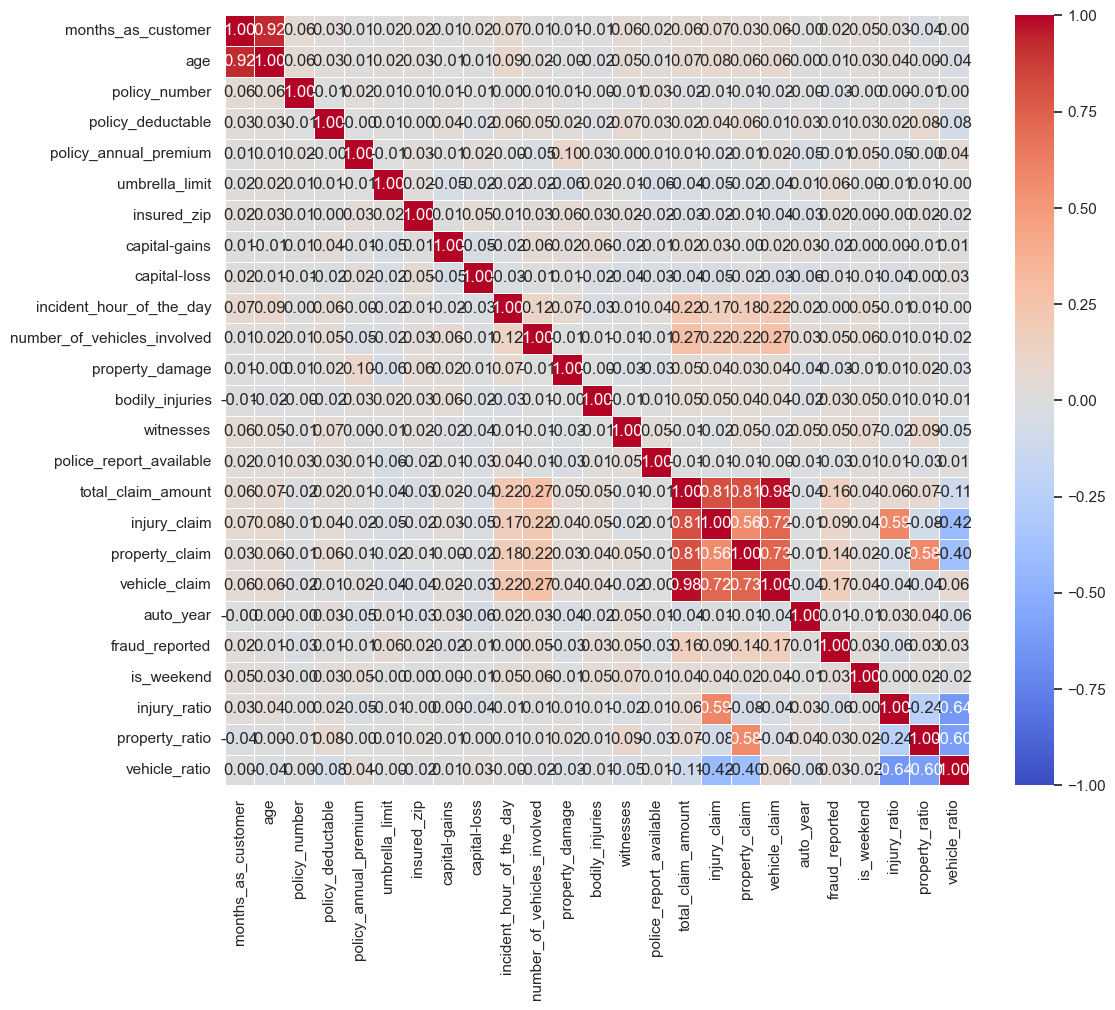

In [121]:
num_cols = df_features.select_dtypes(include=["int64", "float64"]).columns.tolist()

plt.figure(figsize=(12, 10))
correlation_matrix = df_features[num_cols].corr()

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5)

plt.show()

In [122]:
from sklearn.model_selection import train_test_split
X_i = df_features.drop(TARGET_NAME, axis=1)
y_i = df_features[TARGET_NAME]
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=0.25, random_state=42, stratify=y)

Я пробовал и модель и scikit-learn, и xgboost, но последняя показала лучшие результаты. В пайплайне уже по традиции отсутствует нормализация данных, кроме целевой переменной, которая логарифмируется. Также тут я попробовал использовать внутренние инструменты XGBoost, чтобы учесть дисбаланс классов.

In [123]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from collections import Counter

num_cols = X_train_i.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train_i.select_dtypes(include=["object", "category"]).columns.tolist()

categorical_pipe = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False, min_frequency=2))
])

ct = ColumnTransformer([
    ("cat", categorical_pipe, cat_cols)
])

counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

model_pipe = Pipeline([
    ('ct', ct),
    ('model', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    ))
])

param_grid = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 1, 5],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [1, 1.5, 2],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = RandomizedSearchCV(
    model_pipe,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print("Лучшие параметры:", grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_i)
y_prob = best_model.predict_proba(X_test_i)[:, 1]

f1 = f1_score(y_test_i, y_pred)
roc = roc_auc_score(y_test_i, y_prob)

print("-"*30)
print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-"*30)
print("Classification Report:")
print(classification_report(y_test_i, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры: {'model__subsample': 0.8, 'model__reg_lambda': 1.5, 'model__reg_alpha': 0, 'model__n_estimators': 300, 'model__max_depth': 7, 'model__learning_rate': 0.05, 'model__gamma': 5, 'model__colsample_bytree': 1.0}
------------------------------
F1-score (класс 1): 0.7361
ROC-AUC: 0.8543
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       188
           1       0.65      0.85      0.74        62

    accuracy                           0.85       250
   macro avg       0.80      0.85      0.81       250
weighted avg       0.87      0.85      0.85       250



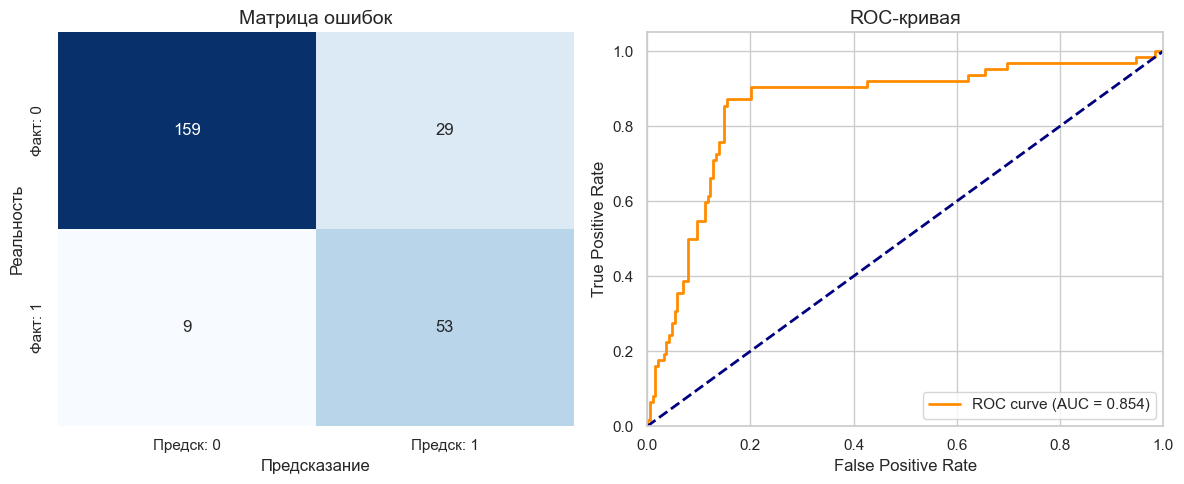

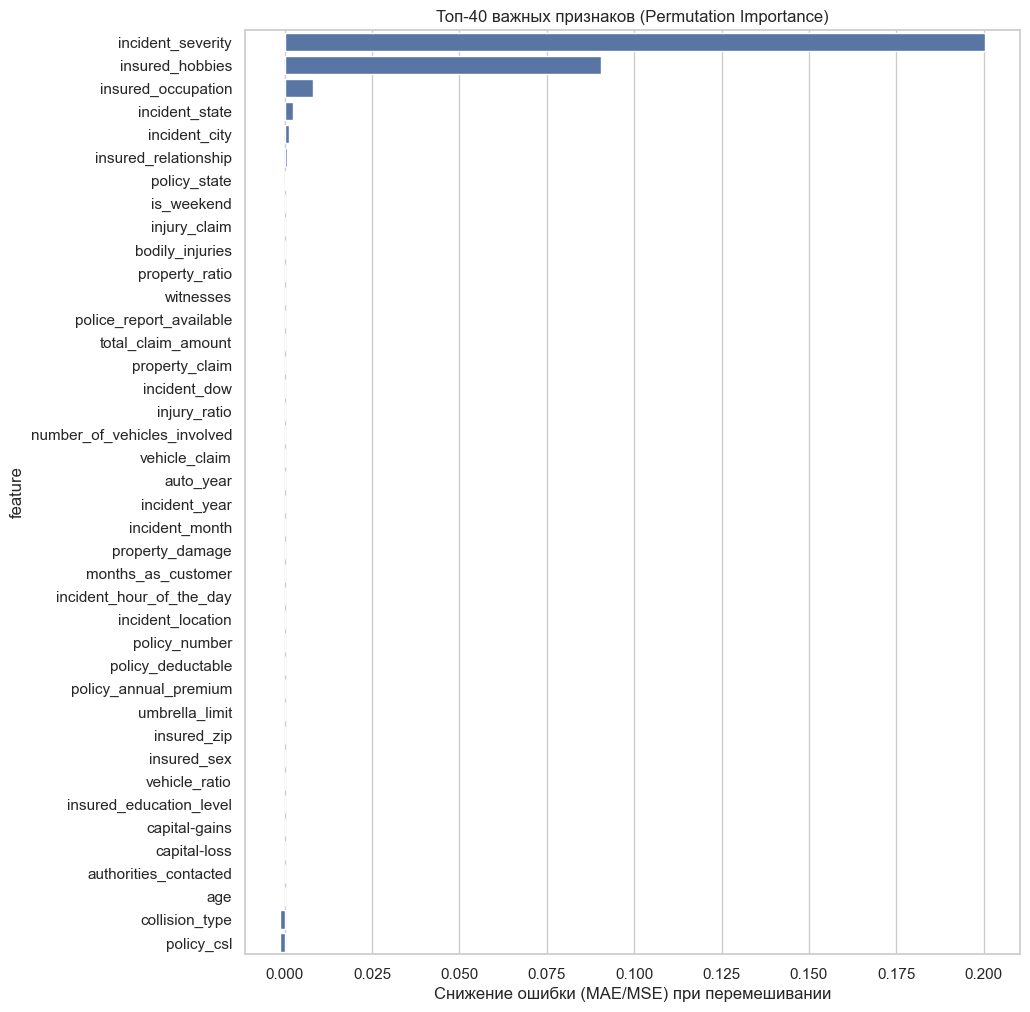

In [124]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance

graphics(y_test_i, y_pred, y_prob)
feature_important(grid.best_estimator_, X_test_i, y_test_i)

Улучшенный бустинг определил больше мошенников, чем случайный лес, нашёл более сложные зависимости по признакам, однако это всё еще хуже, чем обычное дерево. Видимо зависимости, что оно находит, не влияют на количество мошенников, но только увеличивают шанс быть честным человеком. "Грубое" решающее дерево таким не страдает, поэтому F1 на класс мошенников у него выше.

### My implementation

In [125]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class MyGradientBoostingClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.estimators = []
        self.initial_pred = None

    def _sigmoid(self, logit):
        logit = np.clip(logit, -15, 15)
        return 1 / (1 + np.exp(-logit))

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        if len(self.classes_) > 2:
            raise ValueError("This implementation supports binary classification only.")
        p_initial = np.mean(y)
        p_initial = np.clip(p_initial, 1e-15, 1 - 1e-15)
        self.initial_pred = np.log(p_initial / (1 - p_initial))
        current_logits = np.full(y.shape, self.initial_pred)
        self.estimators = []

        for m in range(self.n_estimators):
            current_probabilities = self._sigmoid(current_logits)
            residual = y - current_probabilities
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                random_state=42
            )
            tree.fit(X, residual)

            tree_predictions = tree.predict(X)
            current_logits += self.learning_rate * tree_predictions
            self.estimators.append(tree)

        return self

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        final_logits = np.full(X.shape[0], self.initial_pred)
        for tree in self.estimators:
            tree_predictions = tree.predict(X)
            final_logits += self.learning_rate * tree_predictions

        proba_class_1 = self._sigmoid(final_logits)
        proba_class_0 = 1 - proba_class_1
        return np.vstack((proba_class_0, proba_class_1)).T

    def predict(self, X):
        probas = self.predict_proba(X)[:, 1]
        return np.array([1 if p > 0.5 else 0 for p in probas])


In [126]:
model = MyGradientBoostingClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

F1-score (класс 1): 0.6790
ROC-AUC: 0.8565
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       226
           1       0.62      0.74      0.68        74

    accuracy                           0.83       300
   macro avg       0.77      0.80      0.78       300
weighted avg       0.84      0.83      0.83       300

Confusion Matrix:
[[193  33]
 [ 19  55]]


In [127]:
model_pipe = Pipeline([
    ('ct', ct),
    ('model', MyGradientBoostingClassifier())
])

param_grid = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = RandomizedSearchCV(
    model_pipe,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print("Лучшие параметры:", grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_i)
y_prob = best_model.predict_proba(X_test_i)[:, 1]

f1 = f1_score(y_test_i, y_pred)
roc = roc_auc_score(y_test_i, y_prob)

print("-"*30)
print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-"*30)
print("Classification Report:")
print(classification_report(y_test_i, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры: {'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.1}
------------------------------
F1-score (класс 1): 0.6935
ROC-AUC: 0.8708
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       188
           1       0.69      0.69      0.69        62

    accuracy                           0.85       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.85      0.85      0.85       250



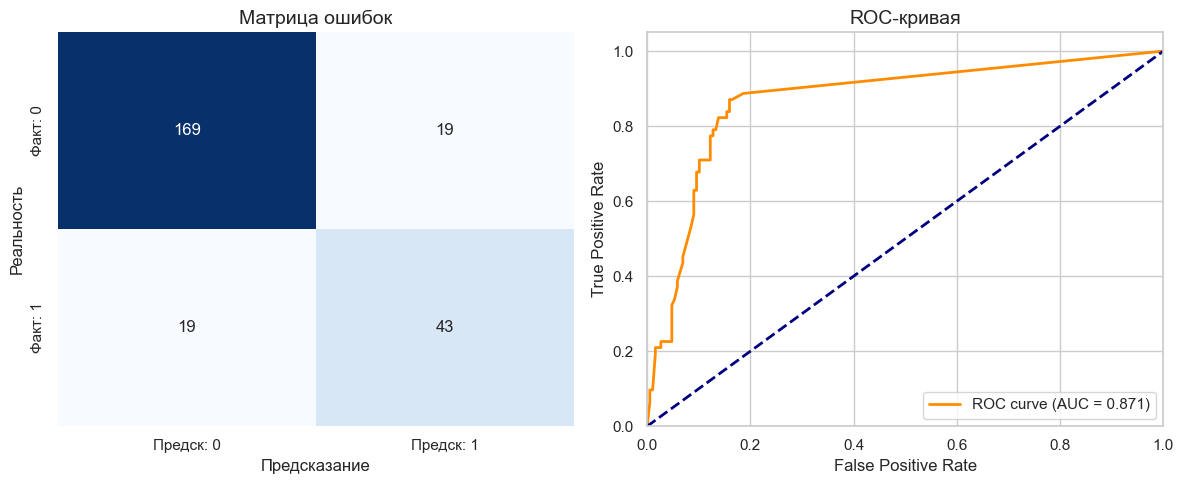

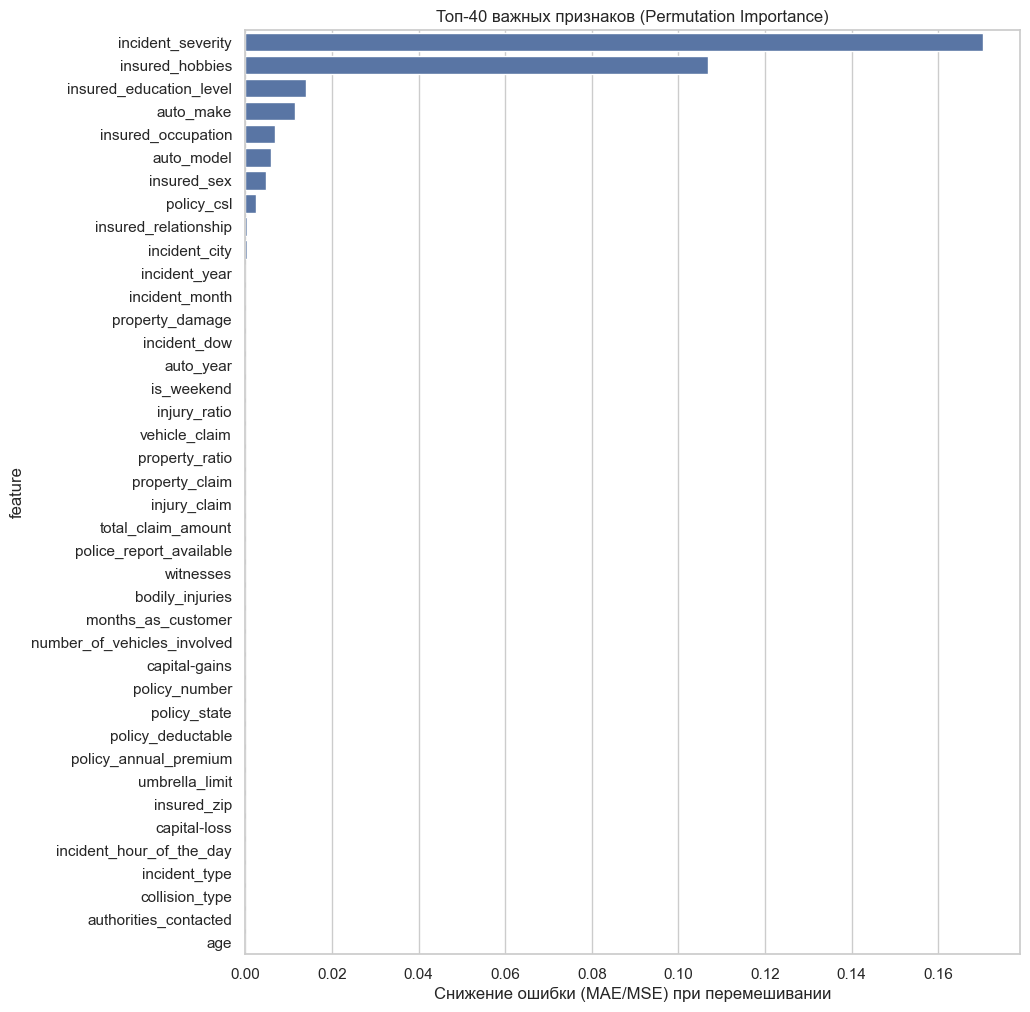

In [128]:
graphics(y_test_i, y_pred, y_prob)
feature_important(grid.best_estimator_, X_test_i, y_test_i)

Собственная реализация градиентного бустинга выдаёт примерно такие результаты, что и версия из XGBoost

|              | Base Random Forest | Random Forest | My Random Forest |
|--------------|--------------------|---------------|------------------|
| ROC_AUC      | 0.8380             | 0.8497        | 0.8677           |
| F1 (1 класс) | 0.88               | 0.88          | 0.89             |
| F1 (2 класс) | 0.65               | 0.67          | 0.63             |

## Вывод

При выполнении этой лабораторной работы я понял, что самая мощная модель не значит, что она будет самая лучшая. Для обоих датасетов и задач менее продвинутые и сложные модели показали лучший результат.

Для задачи классификации бустинг еще показывал результат примерно в рамках погрешности, то для регресси он не смог достаточно точно научиться предсказывать зарплату игроков, которая гораздно выше среднего.